<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Подготовка" data-toc-modified-id="1.-Подготовка-1">1. Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1">Вывод</a></span></li></ul></li><li><span><a href="#2.-Анализ" data-toc-modified-id="2.-Анализ-2">2. Анализ</a></span><ul class="toc-item"><li><span><a href="#2.1-Общая-картина" data-toc-modified-id="2.1-Общая-картина-2.1">2.1 Общая картина</a></span></li><li><span><a href="#2.2-Декомпозиция" data-toc-modified-id="2.2-Декомпозиция-2.2">2.2 Декомпозиция</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.3">Вывод</a></span></li></ul></li><li><span><a href="#3.-Подготовка-данных" data-toc-modified-id="3.-Подготовка-данных-3">3. Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1">Вывод</a></span></li></ul></li><li><span><a href="#4.-Обучение" data-toc-modified-id="4.-Обучение-4">4. Обучение</a></span></li><li><span><a href="#5.-Тестирование" data-toc-modified-id="5.-Тестирование-5">5. Тестирование</a></span><ul class="toc-item"><li><span><a href="#5.1-LinearRegression" data-toc-modified-id="5.1-LinearRegression-5.1">5.1 LinearRegression</a></span></li><li><span><a href="#5.2-RandomForestRegressor" data-toc-modified-id="5.2-RandomForestRegressor-5.2">5.2 RandomForestRegressor</a></span></li><li><span><a href="#5.3-LGBMRegressor" data-toc-modified-id="5.3-LGBMRegressor-5.3">5.3 LGBMRegressor</a></span></li><li><span><a href="#5.4-CatBoostRegressor" data-toc-modified-id="5.4-CatBoostRegressor-5.4">5.4 CatBoostRegressor</a></span></li></ul></li><li><span><a href="#6.-Результаты" data-toc-modified-id="6.-Результаты-6">6. Результаты</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-7">Общий вывод</a></span></li>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import time

from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.iolib.table import SimpleTable

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

RND = 2102

In [2]:
pth1 = '/datasets/taxi.csv'
pth2 = './data/taxi.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, parse_dates=True, index_col=0)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, parse_dates=True, index_col=0)
else:
    print('Something is wrong')

In [3]:
def first_check(df):
    display(df.info())
    print(f'Количество пропусков: {df.isna().sum()}/n')
    display(df.head())
    display(df.describe())
    print(f'Количество дубликатов: {df.duplicated().sum()}')
    print(f'Разнообразие значений: {len(df["num_orders"].unique())}')

In [4]:
first_check(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

Количество пропусков: num_orders    0
dtype: int64/n


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Количество дубликатов: 26415
Разнообразие значений: 81


**Сразу расположем наблюдения в хронологическом порядке.**

In [5]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

print(f'Показатель монотонного увеличения: {df.index.is_monotonic}')

Показатель монотонного увеличения: True


### Вывод

* В наборе данных `26496` наблюдений.
* Разнообразие значений ряда `81`.
* Отсутствие пропусков.
* Данные ресемплированы, расположены в хронологическом порядке.
* Данные подготовленны к анализу.

## 2. Анализ

### 2.1 Общая картина

In [6]:
def jb_test(df):
    """ Тест Харки — Бера для определения номарльности распределения """
    row =  [u'JB(Статистика теста Харке-Бера)', u'p-value', u'skew(асимметрия)', u'kurtosis(эксцесс)']
    jb_test = jarque_bera(df)
    a = np.vstack([jb_test])
    itog = SimpleTable(a, row)
    return itog

In [7]:
def fuller_test(df):
    """ Обобщенный тест Дикки-Фуллера на наличие единичных корней """
    test = adfuller(df)
    
    print('adf: ', test[0])
    print('p-value: ', test[1])
    print('Critical values: ', test[4])
    
    if test[0]> test[4]['5%']: 
        return 'Есть единичные корни, ряд не стационарен'
    else:
        return 'Единичных корней нет, ряд стационарен'

Я заранее сделаю копию фрейма, в котором, после анализа, будем создавать корректные признаки.

In [8]:
final_df = df.copy()

In [9]:
df["rolling_mean"] = df["num_orders"].shift().rolling(24).mean()
df["rolling_std"] = df["num_orders"].shift().rolling(24).std()
df = df.dropna()

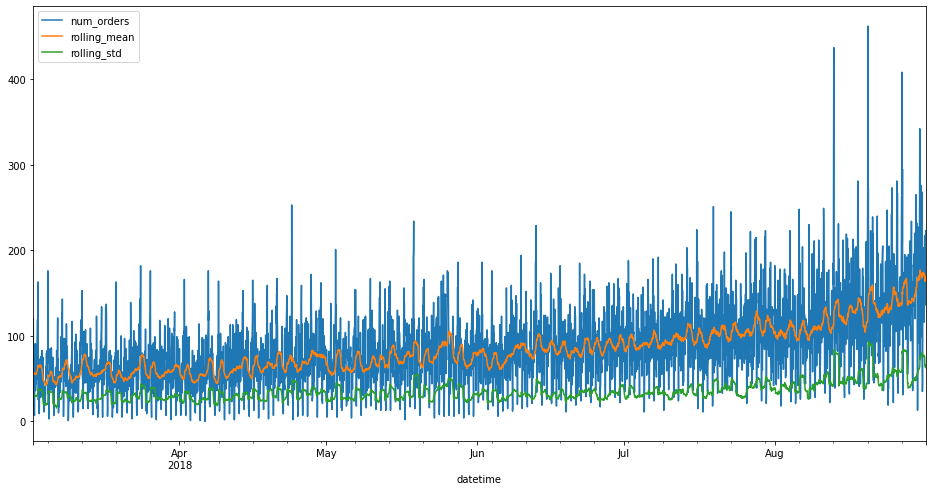

In [10]:
df.plot(figsize=(16, 8))
plt.show()

* Наблюдается тренд на увеличение количества заказов такси от месяца к месяцу

Проведем тест Харки — Бера для определения номарльности распределения, чтобы подтвердить/опровергнуть предположение об однородности.

In [11]:
jb_test(df['num_orders'])

JB(Статистика теста Харке-Бера),p-value,skew(асимметрия),kurtosis(эксцесс)
3620.484352797907,0.0,1.187719647246188,6.7604993896834324


Поскольку p-value меньше 0.05 и значение статистики 3644.43, мы отвергаем нулевую гипотезу. Следовательно у нас есть достаточно доказательств, чтобы сказать, что эти данные значительно отличаются от нормального распределения.

Теперь, для проверки стационарности, давайте проведем обобщенный тест Дикки-Фуллера на наличие единичных корней.

In [12]:
fuller_test(df['num_orders'])

adf:  -3.02570582837002
p-value:  0.03256254040657812
Critical values:  {'1%': -3.431850379108881, '5%': -2.86220298394487, '10%': -2.5671229108274067}


'Единичных корней нет, ряд стационарен'

Проведенный тест подтвердил предположения о стационарности ряда.

### 2.2 Декомпозиция
Проведем декомпозицию для просмотра тренда и сезонности

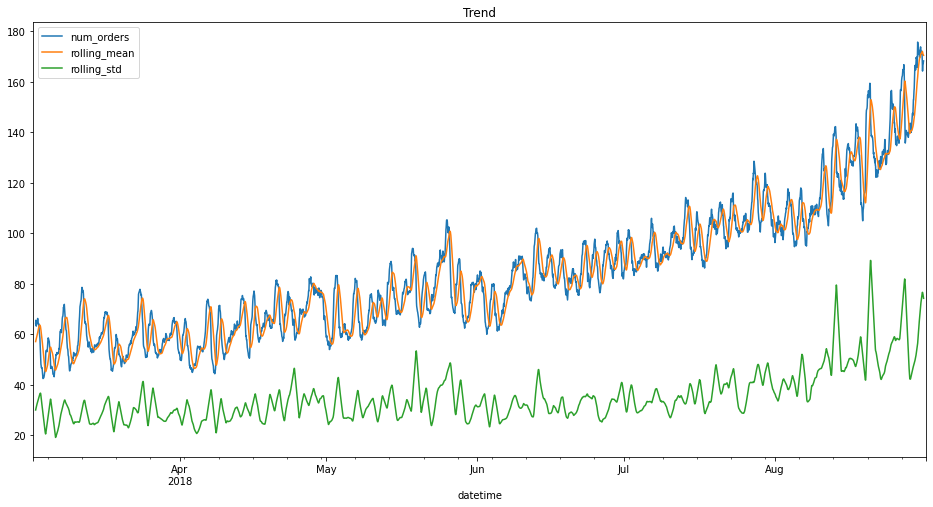

In [13]:
dec_list = [df["num_orders"], df["rolling_mean"], df["rolling_std"]]
legend_list = ['num_orders', "rolling_mean", "rolling_std"]

fig, axs = plt.subplots(1, 1, figsize=(16, 8))

for el in dec_list:
    decomposed_df = seasonal_decompose(el)
    decomposed_df.trend.plot(title='Trend', ax = axs)
    del decomposed_df
    
plt.legend(legend_list)
plt.show()

По данному графику можно сказать, что присутствует восходящий тренд.

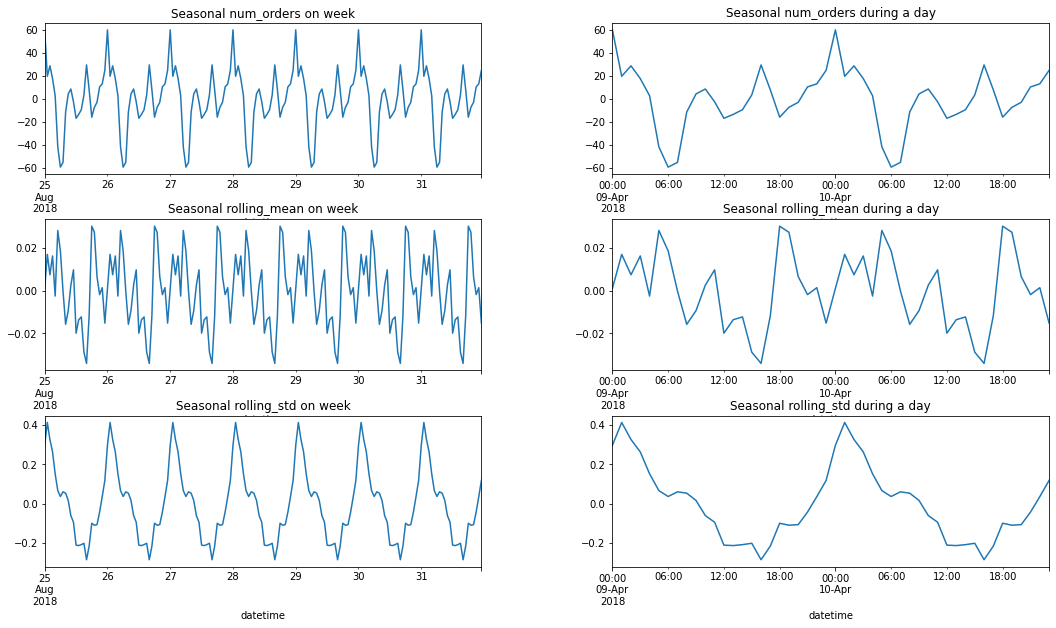

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(18, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for index, elem in enumerate(dec_list):
    decomposed_df = seasonal_decompose(elem)
    decomposed_df.seasonal.tail(24*7).plot(title='Seasonal '+legend_list[index]+' on week', ax=axs[index, 0])
    decomposed_df.seasonal['2018-04-09':'2018-04-10'].plot(title='Seasonal '+legend_list[index]+' during a day', ax=axs[index, 1])
    del decomposed_df
    
plt.show()

Как видно из графика, реже заказывают такси в 6 утра и пик заказов приходится на полночь. Так как мы рассматриваем заказы такси в аэропорту, возможно подобная тенденция связана с работой общественного транспорта.

### Вывод

* Наблюдается тренд на увеличение количества заказов такси от месяца к месяцу.
* Данные значительно отличаются от нормального распределения. (проведен тест Харке-Бера)
* Удалось подтвердить предположения о стационарности ряда, ряд стационарен. (проведен тест Дикки-Фуллера)
* Реже всего такси заказывают в 6 утра, пик заказов 00:00.

## 3. Подготовка данных
Создадим новые признаки:

* `month` - месяц;
* `day` - день;
* `dayofweek` - день недели;
* `hour` - час;
* `lag_n` - отставания;
* `rolling_mean` - скользящее среднее.

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data["num_orders"].shift(lag)

    data['rolling_mean'] = data["num_orders"].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)

In [16]:
make_features(final_df, 25, 20)

In [17]:
final_df

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 01:00:00,120,3,2,4,90.0,58.0,113.0,66.0,61.0,45.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,53.25
2018-03-02 02:00:00,75,3,2,4,120.0,90.0,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,58.95
2018-03-02 03:00:00,64,3,2,4,75.0,120.0,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,62.10
2018-03-02 04:00:00,20,3,2,4,64.0,75.0,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,64.55
2018-03-02 05:00:00,11,3,2,4,20.0,64.0,75.0,120.0,90.0,58.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,63.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,207.0,217.0,197.0,116.0,133.0,166.0,...,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,177.0,169.35
2018-08-31 20:00:00,154,8,31,4,136.0,207.0,217.0,197.0,116.0,133.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,163.85
2018-08-31 21:00:00,159,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,157.75


In [18]:
train, test = train_test_split(final_df, shuffle=False, test_size=0.1)
train, test = train.fillna(0), test.fillna(0)

features_train, target_train = train.drop(['num_orders'], axis=1), train['num_orders']
features_test, target_test = test.drop(['num_orders'], axis=1), test['num_orders']

### Вывод

* Признаки созданы;
* Подготовка к обучению завершена.

## 4. Обучение

In [19]:
def default_model_rmse(model, title):
    """ RMSE на моделях из коробки, отдает кортеж с rmse на обучающей и тестовой выборках """
    model.fit(features_train, target_train)
    train_pred = model.predict(features_train)
    test_pred = model.predict(features_test)
    
    print(f'---- {title} ----')
    print("RMSE обучающей выборки:", mean_squared_error(target_train, train_pred)**0.5)
    print("RMSE тестовой выборки: ", mean_squared_error(target_test, test_pred)**0.5)
    
    return (mean_squared_error(target_train, train_pred)**0.5, mean_squared_error(target_test, test_pred)**0.5)

Предлагаю обучить модели из коробки, они будут служить отправной точкой, c их помощью мы сможем безопасно настроить параметры у каждой из них. (Нам по ТЗ нужно обучить разные модели с **различными гиперпараметрами**, поэтому я решил использовать модели из коробки как отправные точки, на мой взгляд, это удобный способ)

In [20]:
%%time

default_LR = default_model_rmse(LinearRegression(), 'LinearRegression')
default_LR

---- LinearRegression ----
RMSE обучающей выборки: 25.78155080347498
RMSE тестовой выборки:  45.68738572668909
CPU times: total: 15.6 ms
Wall time: 21 ms


(25.78155080347498, 45.68738572668909)

In [21]:
%%time

default_RFR = default_model_rmse(RandomForestRegressor(random_state=RND), 'RandomForestRegressor')
default_RFR

---- RandomForestRegressor ----
RMSE обучающей выборки: 8.5929613603531
RMSE тестовой выборки:  44.01496799901762
CPU times: total: 6.61 s
Wall time: 6.62 s


(8.5929613603531, 44.01496799901762)

In [22]:
%%time

default_LGBMR = default_model_rmse(LGBMRegressor(random_state=RND), 'LGBMRegressor')
default_LGBMR

---- LGBMRegressor ----
RMSE обучающей выборки: 12.204849456840948
RMSE тестовой выборки:  42.86466574410061
CPU times: total: 3.59 s
Wall time: 156 ms


(12.204849456840948, 42.86466574410061)

In [23]:
%%time

default_CB = default_model_rmse(CatBoostRegressor(random_state=RND, verbose=0), 'CatBoostRegressor')
default_CB

---- CatBoostRegressor ----
RMSE обучающей выборки: 10.900896657156775
RMSE тестовой выборки:  40.44925479227379
CPU times: total: 1min 1s
Wall time: 3.5 s


(10.900896657156775, 40.44925479227379)

In [24]:
report = pd.DataFrame(columns = ["LinearRegression", "RandomForest", "LightGBM", "CatBoost"],
                      index = ["RMSE(train)",
                               "RMSE(test)",
                               "Общее время",])


report.iloc[0] = [default_LR[0], default_RFR[0], default_LGBMR[0], default_CB[0]]
report.iloc[1] = [default_LR[1], default_RFR[1], default_LGBMR[1], default_CB[1]]
report.iloc[2] = ['24.3 мс.', '6 с.', '147 мс.', '3.53 с.']

display(report)

,LinearRegression,RandomForest,LightGBM,CatBoost
RMSE(train),25.781551,8.592961,12.204849,10.900897
RMSE(test),45.687386,44.014968,42.864666,40.449255
Общее время,24.3 мс.,6 с.,147 мс.,3.53 с.


## 5. Тестирование

In [25]:
def cv_model_rmse(model, params, title):
    """ RMSE на моделях с наилучшими параметрами, отдает словарь с rmse train/test и и временем fit/predict """
    cv_ts = TimeSeriesSplit(5)
    train_start_time = time.time()
    grid = GridSearchCV(model, param_grid = params, scoring='neg_mean_squared_error', cv=cv_ts, n_jobs=-1, verbose=1)
    grid.fit(features_train, target_train)
    best_params = grid.best_params_

    model.set_params(**grid.best_params_)
    model.fit(features_train, target_train)
    train_total_time = time.time() - train_start_time

    test_start_time = time.time()
    test_pred = model.predict(features_test)
    test_total_time = time.time() - test_start_time
    train_pred = model.predict(features_train)

    print(f'---- {title} ----')
    print('Лучшие гиперпараметры: ', best_params)
    print("RMSE обучающей выборки: ", mean_squared_error(target_train, train_pred)**0.5)
    print("RMSE тестовой выборки: ", mean_squared_error(target_test, test_pred)**0.5)
    
    
    test_spis_ind = []
    test_index = test.index.copy()

    for el in test_index:
        test_spis_ind.append(el)
        
    pred_df = pd.DataFrame(test_pred)
    pred_df['date'] = test_spis_ind
    pred_df['date'] = pd.to_datetime(pred_df['date'])
    pred_df = pred_df.set_index('date')
    pred_df.sort_index(inplace=True)

    return {
        'train_rmse': mean_squared_error(target_train, train_pred)**0.5,
        "test_rmse": mean_squared_error(target_test, test_pred)**0.5,
        'time_fit': train_total_time,
        'time_predict': test_total_time,
        'test_pred_df': pred_df,
        'model': model,
    }

### 5.1 LinearRegression

In [26]:
LR_params = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False],
}

In [27]:
%%time

cv_LR = cv_model_rmse(LinearRegression(n_jobs=-1), LR_params, 'LinearRegression')
cv_LR

Fitting 5 folds for each of 8 candidates, totalling 40 fits
---- LinearRegression ----
Лучшие гиперпараметры:  {'copy_X': True, 'fit_intercept': True, 'normalize': False}
RMSE обучающей выборки:  25.78155080347498
RMSE тестовой выборки:  45.68738572668909
CPU times: total: 344 ms
Wall time: 4.6 s


{'train_rmse': 25.78155080347498,
 'test_rmse': 45.68738572668909,
 'time_fit': 4.581427574157715,
 'time_predict': 0.003998279571533203,
 'test_pred_df':                               0
 date                           
 2018-08-13 16:00:00  117.695673
 2018-08-13 17:00:00   98.462167
 2018-08-13 18:00:00  113.593202
 2018-08-13 19:00:00   91.253378
 2018-08-13 20:00:00   76.193239
 ...                         ...
 2018-08-31 19:00:00  102.766012
 2018-08-31 20:00:00  148.044884
 2018-08-31 21:00:00  176.722591
 2018-08-31 22:00:00  149.383371
 2018-08-31 23:00:00  194.434782
 
 [440 rows x 1 columns],
 'model': LinearRegression(n_jobs=-1, normalize=False)}

### 5.2 RandomForestRegressor

In [28]:
RF_params = {
    'n_estimators': range(100, 150, 10),
    'max_depth': range(1, 15),
}

In [29]:
%%time

cv_RF = cv_model_rmse(RandomForestRegressor(random_state=RND, n_jobs=-1, verbose=0), RF_params, 'RandomForestRegressor')
cv_RF

Fitting 5 folds for each of 70 candidates, totalling 350 fits
---- RandomForestRegressor ----
Лучшие гиперпараметры:  {'max_depth': 14, 'n_estimators': 140}
RMSE обучающей выборки:  10.119624623105333
RMSE тестовой выборки:  43.827002546749505
CPU times: total: 26.3 s
Wall time: 49.6 s


{'train_rmse': 10.119624623105333,
 'test_rmse': 43.827002546749505,
 'time_fit': 49.45147657394409,
 'time_predict': 0.041001081466674805,
 'test_pred_df':                               0
 date                           
 2018-08-13 16:00:00  153.482839
 2018-08-13 17:00:00  135.795412
 2018-08-13 18:00:00  102.297077
 2018-08-13 19:00:00  103.614622
 2018-08-13 20:00:00  100.768831
 ...                         ...
 2018-08-31 19:00:00  125.174246
 2018-08-31 20:00:00  172.081148
 2018-08-31 21:00:00  170.079792
 2018-08-31 22:00:00  148.257785
 2018-08-31 23:00:00  165.622005
 
 [440 rows x 1 columns],
 'model': RandomForestRegressor(max_depth=14, n_estimators=140, n_jobs=-1,
                       random_state=2102)}

### 5.3 LGBMRegressor

In [30]:
LGBMR_params = {
    'n_estimators' : range(50, 101, 10),
    'max_depth' : range(5, 15, 2),
    'num_leaves' : range(1, 28, 3)
}

In [31]:
%%time

cv_LGBMR = cv_model_rmse(LGBMRegressor(random_state=RND, n_jobs=-1, verbose=0, force_col_wise=True), LGBMR_params, 'LGBMRegressor')
cv_LGBMR

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
---- LGBMRegressor ----
Лучшие гиперпараметры:  {'max_depth': 9, 'n_estimators': 90, 'num_leaves': 16}
RMSE обучающей выборки:  16.913555591519568
RMSE тестовой выборки:  41.80525346463503
CPU times: total: 13.5 s
Wall time: 12.5 s


{'train_rmse': 16.913555591519568,
 'test_rmse': 41.80525346463503,
 'time_fit': 12.482000589370728,
 'time_predict': 0.001996755599975586,
 'test_pred_df':                               0
 date                           
 2018-08-13 16:00:00  155.072792
 2018-08-13 17:00:00  149.498497
 2018-08-13 18:00:00  110.724120
 2018-08-13 19:00:00  109.030618
 2018-08-13 20:00:00  111.946284
 ...                         ...
 2018-08-31 19:00:00  122.406059
 2018-08-31 20:00:00  164.894201
 2018-08-31 21:00:00  165.446561
 2018-08-31 22:00:00  148.112399
 2018-08-31 23:00:00  163.153937
 
 [440 rows x 1 columns],
 'model': LGBMRegressor(force_col_wise=True, max_depth=9, n_estimators=90, num_leaves=16,
               random_state=2102, verbose=0)}

### 5.4 CatBoostRegressor

In [32]:
CB_params = {
    'iterations': [2000],
    'bootstrap_type': ['Bernoulli'],
}

In [33]:
%%time

cv_CB = cv_model_rmse(CatBoostRegressor(random_state=RND, verbose=0), CB_params, 'CatBoostRegressor')
cv_CB

Fitting 5 folds for each of 1 candidates, totalling 5 fits
---- CatBoostRegressor ----
Лучшие гиперпараметры:  {'bootstrap_type': 'Bernoulli', 'iterations': 2000}
RMSE обучающей выборки:  10.084194969239546
RMSE тестовой выборки:  40.08533339076403
CPU times: total: 3min 55s
Wall time: 25.4 s


{'train_rmse': 10.084194969239546,
 'test_rmse': 40.08533339076403,
 'time_fit': 25.37856698036194,
 'time_predict': 0.00599980354309082,
 'test_pred_df':                               0
 date                           
 2018-08-13 16:00:00  153.064619
 2018-08-13 17:00:00  155.766609
 2018-08-13 18:00:00  115.856623
 2018-08-13 19:00:00  107.529155
 2018-08-13 20:00:00  101.264063
 ...                         ...
 2018-08-31 19:00:00  138.253575
 2018-08-31 20:00:00  162.437759
 2018-08-31 21:00:00  174.796164
 2018-08-31 22:00:00  173.892885
 2018-08-31 23:00:00  183.473541
 
 [440 rows x 1 columns],
 'model': <catboost.core.CatBoostRegressor at 0x1a62af19b40>}

## 6. Результаты

In [34]:
report = pd.DataFrame(columns = ["LinearRegression", "RandomForest", "LightGBM", "CatBoost"],
                      index = ["RMSE(train)",
                               "RMSE(test)",
                               "Время обучения (секунды)",
                               "Время предсказания (секунды)",])


report.iloc[0] = [cv_LR['train_rmse'], cv_RF['train_rmse'], cv_LGBMR['train_rmse'], cv_CB['train_rmse']]
report.iloc[1] = [cv_LR['test_rmse'], cv_RF['test_rmse'], cv_LGBMR['test_rmse'], cv_CB['test_rmse']]
report.iloc[2] = [cv_LR['time_fit'], cv_RF['time_fit'], cv_LGBMR['time_fit'], cv_CB['time_fit']]
report.iloc[3] = [cv_LR['time_predict'], cv_RF['time_predict'], cv_LGBMR['time_predict'], cv_CB['time_predict']]

display(report)

,LinearRegression,RandomForest,LightGBM,CatBoost
RMSE(train),25.781551,10.119625,16.913556,10.084195
RMSE(test),45.687386,43.827003,41.805253,40.085333
Время обучения (секунды),4.581428,49.451477,12.482001,25.378567
Время предсказания (секунды),0.003998,0.041001,0.001997,0.006


Основываясь на полученные результаты можно сделать вывод:
* Все рассмотренные модели преодолели порог в `48`.
* Наименьшую ошибку на тесте выдёт `CatBoost`.
* `LinearRegression` самая быстрая модель.

Основываясь на этом, можно сделать вывод, что лучше всего спросить заказчика о наиболее важных параметрах модели, если важна скорость, то преимущество у `LinearRegression`, если важна точность, то у `CatBoost`, если важна скорость **и** точность, то сможем предложить `LightGBM`, т.к. у него хорошая скорость, а по скору он немного проигрывает `CatBoost`.

In [35]:
def plotImp(model, X , num = 30, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title('LightGBM feature importance')
    plt.tight_layout()
    plt.show()

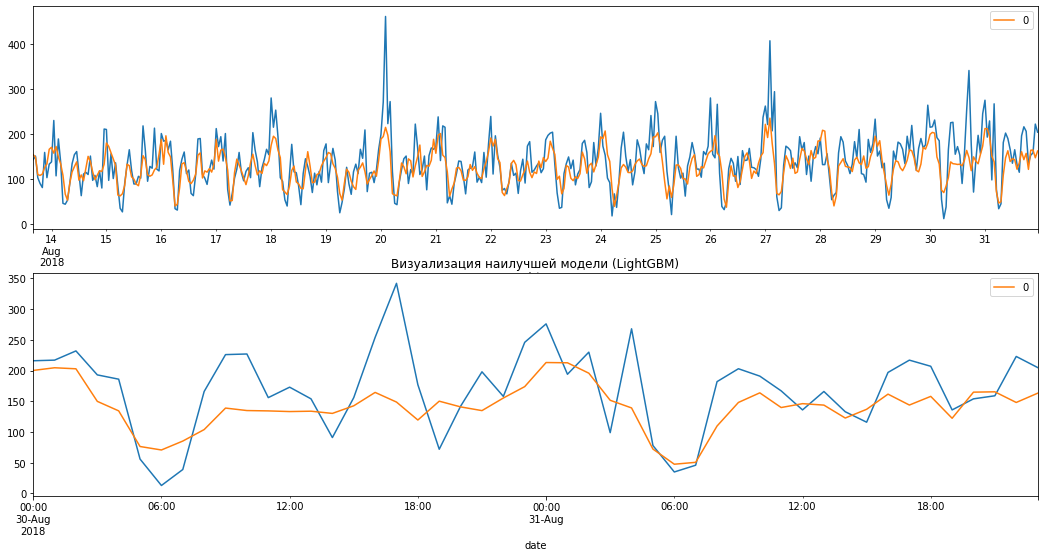

In [36]:
# subplot
fig, axs = plt.subplots(2, 1, figsize=(18, 9))

test['num_orders'].plot(ax=axs[0])
cv_LGBMR['test_pred_df'].plot(ax=axs[0])
plt.title('Визуализация наилучшей модели (LightGBM)')
plt.legend(['y_true', 'y_pred'])

test['num_orders'].tail(48).plot(ax=axs[1])
cv_LGBMR['test_pred_df'].tail(48).plot(ax=axs[1])
plt.show()

Модель хуже всего справляется с предсказаниями на высоких пиках и на провалах, но в целом, угадывает направление движения.

In [37]:
sns.set(font_scale = 2)

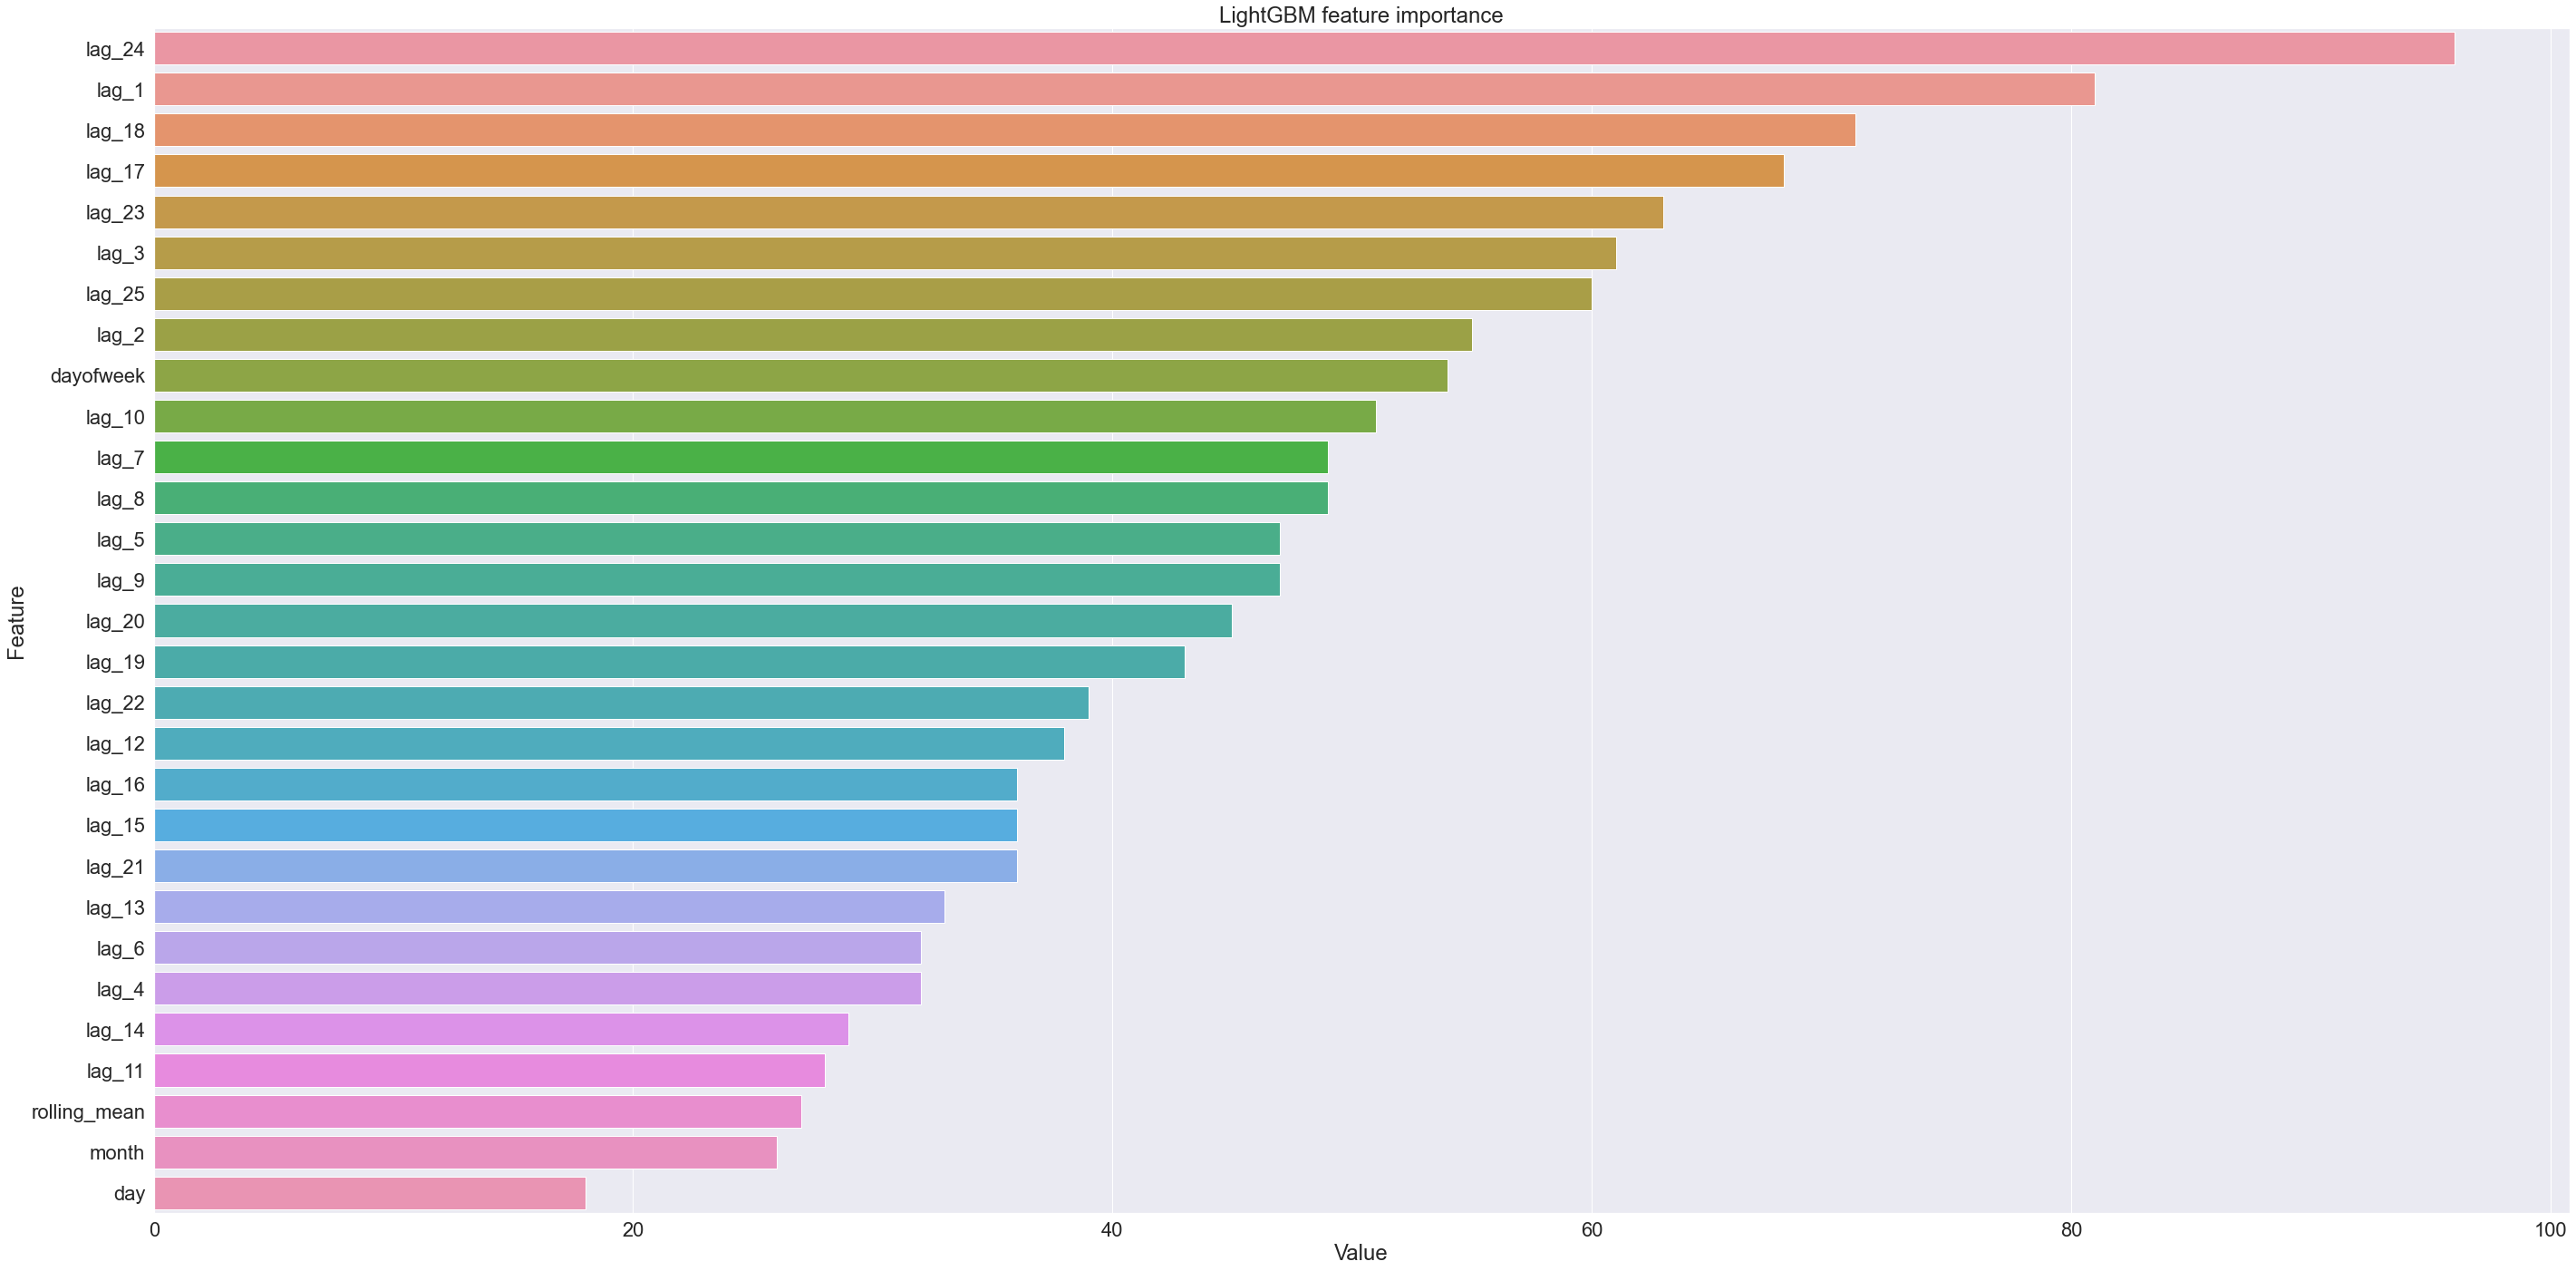

In [38]:
plotImp(cv_LGBMR['model'], features_train)

Модель выделила `'lag_24'`, как самый важный признак.

## Общий вывод

При выполнении проекта проделана следующая работа:
* На первом этапе произведена загрузка данных и их подготовка для обучения моделей;
* За время наблюдений наметился определенный тренд на общее увеличение заказов такси в течение часа, которое скорее всего вызвано работой общественного транспорта. На графиках явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.
* На третьем этапе к датасету были добавлены дополнительные признаки, а именно день недели, час "отстающие значения" и скользящее среднее. 
* На четвертом и пятом этапах проведено тестирование всех моделей, каждой из них удалось достичь требуемого показателя метрики RMSE. Путем проверки обученных моделей на тестовых выборках, пришли к выводу, что модель `LGBMRegressor` дает лучшие показатели.
* На шестом этапе провели сравнительный анализ графиков в двух масштабах, показал, что модель хуже всего справляется с предсказаниями на высоких пиках и на провалах, но в целом, угадывает направление движения.